In [2]:
from __future__ import print_function
import requests
import sys
import io
import json
import shutil
import sys
import datetime
import subprocess
import sys
import os
import math
import base64
from time import gmtime, strftime
import random, string
import time
import psutil
import base64
import uuid
import socket
import os
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
import torch
from torchvision import transforms
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from pymilvus import MilvusClient
import os
from IPython.display import display

In [3]:
# -----------------------------------------------------------------------------

class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

In [4]:
extractor = FeatureExtractor("resnet34")


In [5]:
# Milvus Constants
COLLECTION_NAME = 'nycstreetcams'  # Collection name
DIMENSION = 512 
MILVUS_URL = "http://192.168.1.163:19530" 

In [6]:
# -----------------------------------------------------------------------------
# Connect to Milvus

# Milvus Lite
# milvus_client = MilvusClient(uri="streetcams.db")

# Local Docker Server
milvus_client = MilvusClient( uri=MILVUS_URL)

In [7]:
query_image = "street1.png"

results = milvus_client.search(
    COLLECTION_NAME,
    data=[extractor(query_image)],
    output_fields=["filepath", "url", "videourl", "roadwayname", "name", "latlong", "directionoftravel", "id"],
    search_params={"metric_type": "COSINE"},
)

[{'id': 450290875605759294, 'distance': 0.7163988947868347, 'entity': {'directionoftravel': 'Westbound', 'id': 450290875605759294, 'filepath': 'camimages/20240607133429_4f34fed9-fc05-4c5c-9dd9-bd1f8865f726.png', 'url': 'https://511ny.org/map/Cctv/1868--1#20240607133429_4f34fed9-fc05-4c5c-9dd9-bd1f8865f726', 'videourl': 'https://s52.nysdot.skyvdn.com:443/rtplive/R10_012/playlist.m3u8', 'roadwayname': 'I-495', 'name': 'I-495 at New Hyde Park Rd', 'latlong': '40.770817,-73.687524'}}, {'id': 450290875605759292, 'distance': 0.6993396282196045, 'entity': {'directionoftravel': 'Eastbound', 'id': 450290875605759292, 'filepath': 'camimages/20240607133425_7b05e971-eec0-41ec-9ed9-99d7273fd959.png', 'url': 'https://511ny.org/map/Cctv/1867--1#20240607133425_7b05e971-eec0-41ec-9ed9-99d7273fd959', 'videourl': 'https://s52.nysdot.skyvdn.com:443/rtplive/R10_011/playlist.m3u8', 'roadwayname': 'I-495', 'name': 'I-495 West of New Hyde Park Rd', 'latlong': '40.767013,-73.696306'}}, {'id': 45029087560575929

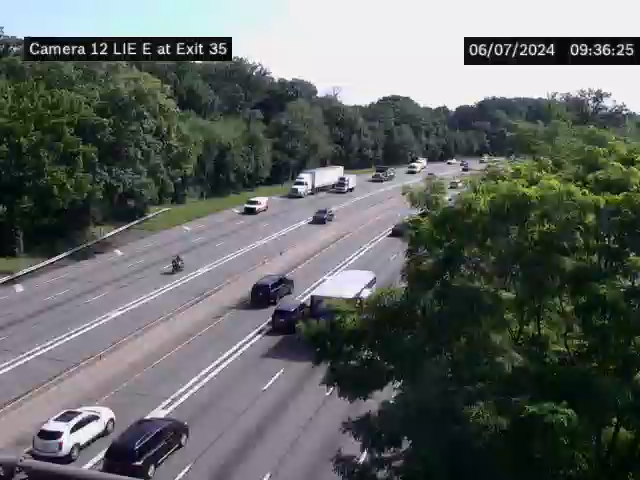

camimages/20240607133425_7b05e971-eec0-41ec-9ed9-99d7273fd959.png
I-495


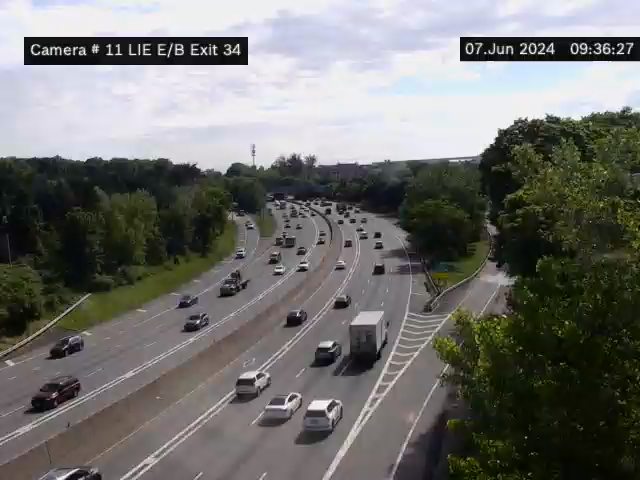

camimages/20240607133431_e31713e0-a59d-4ec2-9f6b-7af1eb1cbb7c.png
I-495


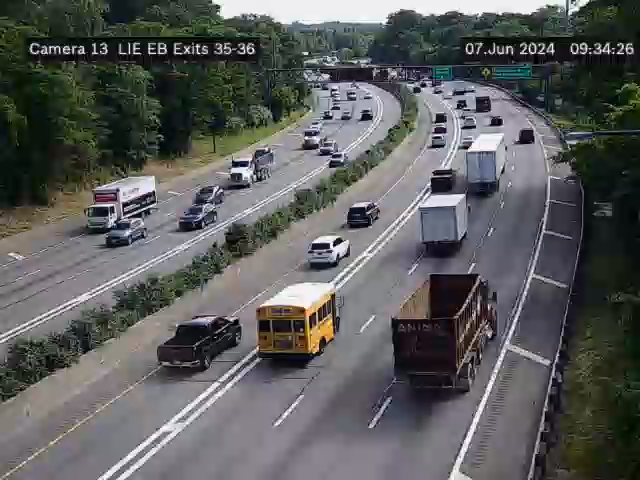

In [9]:
images = []
for result in results:
    print(result)
    for hit in result[:10]:
        filepath = hit["entity"]["filepath"]
        img = Image.open(filepath)
        print(filepath)
        print(hit["entity"]["roadwayname"])
        display(img)